In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/handwritten-mongolian-cyrillic-characters-database/HMCC letters merged.csv
/kaggle/input/handwritten-mongolian-cyrillic-characters-database/HMCC similar merged.csv
/kaggle/input/handwritten-mongolian-cyrillic-characters-database/HMCC balanced.csv
/kaggle/input/handwritten-mongolian-cyrillic-characters-database/HMCC all.csv


In [2]:
data = pd.read_csv('/kaggle/input/handwritten-mongolian-cyrillic-characters-database/HMCC similar merged.csv')

In [3]:
data.head()

,40,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617,0.618
0,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,39,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
data = data.to_numpy()

In [5]:
x,y = data[:,1:], data[:,0]

In [6]:
print(x[:10], y[:10])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] [16 39 12 26  7 43 18 26  3 40]


In [7]:
print(x.shape, y.shape)

(257249, 784) (257249,)


In [8]:
image = x[0].reshape(28,28)

In [9]:
print(y.max())

48


In [10]:
import matplotlib.pyplot as plt

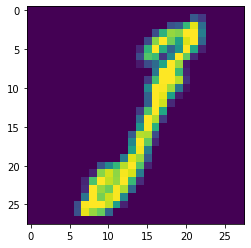

In [11]:
plt.imshow(image)
plt.show()

In [12]:
x = x.reshape((-1,1,28,28))/x.max()
print(x.shape)

(257249, 1, 28, 28)


In [13]:
from torch.utils.data import Dataset, DataLoader
class mmnist(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [14]:
X_train, y_train = x[:int(len(x)*0.7)], y[:int(len(y)*0.7)]
X_test, y_test = x[int(len(x)*0.7):], y[int(len(y)*0.7):]

In [15]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(180074, 1, 28, 28) (180074,) (77175, 1, 28, 28) (77175,)


In [16]:
print(X_train[0][0][:10][:10])

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.27843137 0.16862745 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.25098039 0.29803922 0.66666667 0.96078431 0.36078431 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.    

In [17]:
train_set = mmnist(X_train, y_train)
test_set =mmnist(X_test, y_test)

In [18]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [19]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [20]:
import time
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import torchvision.models as models
import torch.optim as optim

In [21]:
resnet18 = models.resnet18(pretrained=True)
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet18.fc = nn.Linear(resnet18.fc.in_features,y.max()+1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [22]:
def train_model(model, train_loader, test_loader, criterion, optimizer, device, scheduler, num_epochs=25, is_train=True, NN=False):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0
    model.to(device)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        running_loss = 0.0
        running_corrects = 0
        model.train()
        # Iterate over data.
        for inputs, labels in train_loader:
            if NN:
              inputs = inputs.flatten(1,-1)
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            # forward
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            # backward
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        print('Loss: {:.4f} Acc: {:.4f} Lr: {:.8f}'.format(epoch_loss, epoch_acc, optimizer.param_groups[0]['lr']))
        test_model(model, test_loader, criterion, device, scheduler, NN)

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history
def test_model(model, test_loader, criterion, device, scheduler, NN=False):
  model.eval()
  best_acc = 0.0
  test_loss = 0.0
  test_corrects = 0
  for inputs, labels in test_loader:
    if NN:
      inputs = inputs.flatten(1,-1)
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs.float())
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)
    test_loss += loss.item() * inputs.size(0)
    test_corrects += torch.sum(preds == labels.data)
  epoch_acc = test_corrects.double() / len(test_loader.dataset)
  scheduler.step(test_loss)
  print('Test Acc: {:.4f}'.format(epoch_acc))

  if epoch_acc > best_acc:
      best_acc = epoch_acc
      torch.save(model.state_dict(), './best_model_teacher.pt')


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup the loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=5)
# Train model
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, test_loader, criterion, optimizer, device, scheduler)

Epoch 0/24
----------
Loss: 0.7141 Acc: 0.7839 Lr: 0.00100000
Test Acc: 0.8588
Epoch 1/24
----------
Loss: 0.3712 Acc: 0.8813 Lr: 0.00100000
Test Acc: 0.9059
Epoch 2/24
----------
Loss: 0.2936 Acc: 0.9034 Lr: 0.00100000
Test Acc: 0.9081
Epoch 3/24
----------
Loss: 0.2419 Acc: 0.9189 Lr: 0.00100000
Test Acc: 0.9242
Epoch 4/24
----------
Loss: 0.2041 Acc: 0.9302 Lr: 0.00100000
Test Acc: 0.9229
Epoch 5/24
----------
Loss: 0.1738 Acc: 0.9397 Lr: 0.00100000
Test Acc: 0.9301
Epoch 6/24
----------
Loss: 0.1542 Acc: 0.9455 Lr: 0.00100000
Test Acc: 0.9353
Epoch 7/24
----------
Loss: 0.1319 Acc: 0.9528 Lr: 0.00100000
Test Acc: 0.9344
Epoch 8/24
----------
Loss: 0.1173 Acc: 0.9573 Lr: 0.00100000
Test Acc: 0.9390
Epoch 9/24
----------
Loss: 0.1044 Acc: 0.9621 Lr: 0.00100000
Test Acc: 0.9408
Epoch 10/24
----------
Loss: 0.0926 Acc: 0.9664 Lr: 0.00100000
Test Acc: 0.9409
Epoch 11/24
----------
Loss: 0.0822 Acc: 0.9695 Lr: 0.00100000
Test Acc: 0.9430
Epoch 12/24
----------
Loss: 0.0759 Acc: 0.9718 Lr